In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2 
from google.colab.patches import cv2_imshow
from PIL import Image
import sys
import math
import random
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise


%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


## Functrion

In [0]:
def progress_bar(count, total):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % (bar, percents))
    sys.stdout.flush()

def plot_loss_accuracy(history,what_to_plot):
  figure(num=None, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(history[what_to_plot])
  plt.plot(history['val_'+what_to_plot])
  plt.title(what_to_plot + " plot per epochs" )
  plt.ylabel(what_to_plot)
  plt.xlabel('epoch')
  plt.legend(['train_data', 'validation_data'], loc='center right')
  plt.show()


def plot_confusion_matrix(cm,class_names, title='Confusion matrix', cmap='viridis'):
  
    figure(num=None, figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
           plt.text(j, i, cm[i,j],ha="center", va="center")

    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_random_numbers(range_, number):
  randomlist = []
  for i in range(number):
    n = random.randint(range_[0], range_[1])
    randomlist.append(n)
  return randomlist

## data prepration

In [0]:
height = 35
width = 35
channels = 3
num_classes = 43
n_inputs = height * width * channels

dataset_path = "/content/drive/My Drive/german_trafficsign_dataset/"

### train data

In [0]:
train_data_=[]
train_labels_=[]

for i in range(num_classes) :
  path = dataset_path + "Train/" + str(i)
  class_data_names = os.listdir(path)
  
  print("\n class: ",i)
  print("number of class data: ",len(class_data_names))

  for j in range(len(class_data_names)):
    if(j%100 == 0):
      progress_bar(j,len(class_data_names))
    try:
      # name = class_data_names[j]
      # path_to_image = path + "/" + name
      # image = cv2.imread(path_to_image)
      # image = cv2.resize(image, (height, width))
      # train_data_.append(np.array(image))
      train_labels_.append(i)
      # cv2_imshow(image)
    except AttributeError:
      print(" ")
# np.save("train_data",train_data_)

In [0]:
#load saved file because the above code takes to much to run in google colab
train_data_ = np.load("/content/drive/My Drive/german_trafficsign_dataset/train_data.npy")

In [0]:
indexes = np.arange(len(train_labels_))
np.random.seed(85)
np.random.shuffle(indexes)

train_data = np.array(train_data_)
train_labels = np.array(train_labels_)
train_data = train_data[indexes]/255
train_labels = train_labels[indexes]

#prepare labels and make it one hot

train_labels = to_categorical(train_labels,num_classes)

### test data

In [0]:
test_csv = pd.read_csv("/content/drive/My Drive/german_trafficsign_dataset/Test.csv")
test_data_paths = test_csv['Path'].values
test_labels_ = test_csv['ClassId'].values

# test_data_=[]
# for i in range(len(test_data_paths)):
#   print(i)
#   if(i%100 == 0):
#     progress_bar(i,len(test_data_paths))
#   try:
#     name = test_data_paths[i]
#     path_to_image = dataset_path + name
#     image = cv2.imread(path_to_image)
#     image = cv2.resize(image, (height, width))
#     test_data_.append(np.array(image))
#   except AttributeError:
#     print(" ")
# np.save("test_data",test_data_)

test_data_ = np.load("/content/drive/My Drive/german_trafficsign_dataset/test_data.npy")
test_data = test_data_/255

test_labels = np.array(test_labels_)
test_labels = to_categorical(test_labels, num_classes)

## data perpration better way

In [0]:
height = 35
width = 35
channels = 3
num_classes = 43
n_inputs = height * width * channels

dataset_path = "/content/drive/My Drive/german_trafficsign_dataset/"
test_csv = pd.read_csv("/content/drive/My Drive/german_trafficsign_dataset/Test.csv")

train_labels_=[]
num_train_data_per_class ={}
for i in range(num_classes) :
  path = dataset_path + "Train/" + str(i)
  class_data_names = os.listdir(path)
  num_train_data_per_class[i] = len(class_data_names)
  for j in range(len(class_data_names)):
      train_labels_.append(i)

train_labels = to_categorical(train_labels_,num_classes)
train_data_ = np.load(dataset_path + "train_data.npy")

test_data_paths = test_csv['Path'].values
test_labels_ = test_csv['ClassId'].values
test_labels = np.array(test_labels_)
test_labels = to_categorical(test_labels, num_classes)
test_data_ = np.load(dataset_path + "test_data.npy")
test_data = test_data_/255

mini batch and validation split:

In [0]:
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data_, train_labels, test_size=0.1, random_state=42)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow(train_data, train_labels, batch_size=BATCH_SIZE)
validation_data_gen = validation_image_generator.flow(validation_data, validation_labels, batch_size=BATCH_SIZE, shuffle=False)

# Data Augmantaion

## method1:

In [0]:
augmented_train_image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
augmented_train_data_gen = augmented_train_image_generator.flow(train_data, train_labels, batch_size=32)

## method2:

In [0]:
def get_random_transformed_image(image):
  my_gen =  ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=35,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
  random_transform_params = my_gen.get_random_transform((35, 35, 3))
  return my_gen.apply_transform(image, random_transform_params)

In [0]:
train_data_devided = {}
for i in range(num_classes):
  train_data_devided[i] = []
for i in range(train_data.shape[0]):
  train_data_devided[train_labels[i].argmax()].append(train_data[i])

In [0]:
augmented_train_data = []
augmented_train_labels = []

for i in range(num_classes):
  count_to_augment = 1000 - len(train_data_devided[i])
  indexes = generate_random_numbers([0,len(train_data_devided[i])-1], count_to_augment)
  for j in indexes:
    augmented_train_data.append(get_random_transformed_image(train_data_devided[i][j]))
    augmented_train_labels.append(to_categorical(i, num_classes))


In [0]:
augmented_and_original_train_data = np.concatenate((train_data,augmented_train_data), axis=0)
augmented_and_original_train_labels = np.concatenate((train_labels,augmented_train_labels), axis=0)
augmented_train_data_gen = train_image_generator.flow(augmented_and_original_train_data, augmented_and_original_train_labels, batch_size=BATCH_SIZE)

In [0]:
# def h_flip(image):
#   return np.array(tf.image.flip_left_right(image))

# def v_flip(image):
#   return np.array(tf.image.flip_up_down(image))

# def center_crop(image):
#   return np.array(tf.image.central_crop(image, central_fraction=0.5))

# def random_transform_image(image, final_height, final_width):
#   transformations = {'horizontal flip': h_flip, 
#                       'vertical flip': v_flip,
#                      'center crop': center_crop}

# data_generator = ImageDataGenerator(brightness_range=(0.1, 0.9))

#   transformed_image = image
#   transformation_count = random.randint(1, len(transformations)) 
#   for i in range(transformation_count):
#       key = random.choice(list(transformations))
#       transformed_image = transformations[key](transformed_image)

#   return cv2.resize(transformed_image, (final_height, final_width))

# define model and train

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

def build_model(batch_normalization):
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=(4, 4), activation='relu', input_shape = (train_data_.shape[1:])))
  if batch_normalization: model.add(BatchNormalization())
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
  if batch_normalization: model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
  if batch_normalization: model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))

  #Compilation of the model
  model.compile(
      loss='categorical_crossentropy', 
      optimizer='adam', 
      metrics=['accuracy']
  )
  return model

def step_decay(epoch):
  initial_lrate = 0.001
  drop = 0.5
  epochs_drop = 10
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

In [0]:
model_name = "drop_out_relu_aug_method2"
model_path = "/content/drive/My Drive/german_trafficsign_dataset/my_models/my_model_"

model = build_model(0)
# model.load_weights("/content/drive/My Drive/german_trafficsign_dataset/my_models/my_model_drop_out_relu_with_augmnet_40.ckpt")
# model = load_model("/content/drive/My Drive/german_trafficsign_dataset/my_models_final/my_model_drop_out_relu_with_augmnet_method1_40_80.h5")
model.summary()


lrate = keras.callbacks.LearningRateScheduler(step_decay, verbose=0)
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

check_point_save = ModelCheckpoint(filepath = model_path + model_name +"_{epoch}"+".h5",
                                                 save_weights_only=False,
                                                 verbose=1, period=10)

history = model.fit(augmented_train_data_gen,
                    epochs = 100,
                    steps_per_epoch = augmented_and_original_train_data.shape[0]//BATCH_SIZE,
                    validation_data = validation_data_gen,
                    validation_steps = validation_data.shape[0] // BATCH_SIZE,
                    callbacks = [lrate, check_point_save])

save model and history

In [0]:
import csv

model.save("/content/drive/My Drive/german_trafficsign_dataset/my_models_final/my_model_" + model_name + ".h5") 

my_dic = history.history
zd = zip(*my_dic.values())
with open("/content/drive/My Drive/german_trafficsign_dataset/my_models_final/history_" + model_name + ".csv", 'w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(my_dic.keys())
    writer.writerows(zd)

# Evaluation

In [0]:
plot_loss_accuracy(history.history, "loss")

In [14]:
loss, accuracy = model.evaluate(test_data, test_labels, verbose=2)
print("model accurracy : ", accuracy)

model accurracy :  0.963341236114502


confusion matrix:

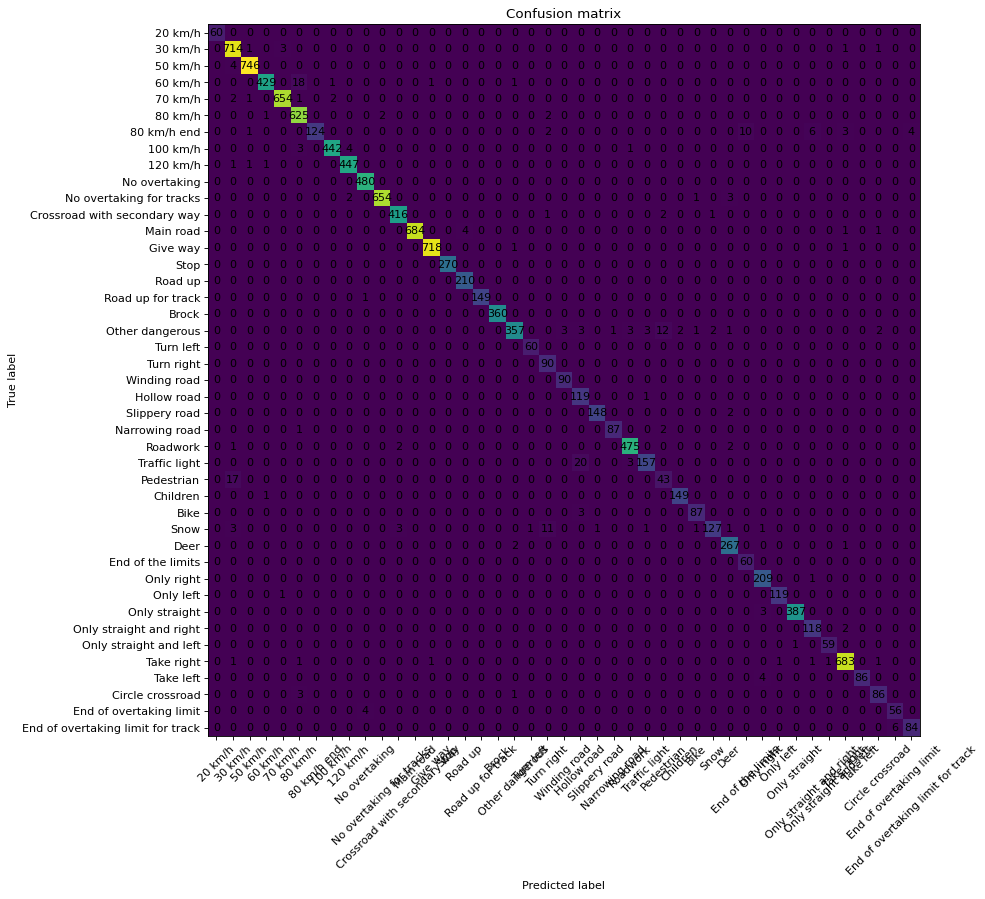

In [0]:
class_names = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

predictions = model.predict(test_data)
predicted_labels=[]
for pred in predictions:
  predicted_labels.append(np.argmax(pred))


color_maps =['viridis',
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cm = confusion_matrix(test_labels_, predicted_labels)
np.set_printoptions(precision=2)

plot_confusion_matrix(cm, class_names, cmap=color_maps[0])